## Cab Driver Agent
---


In [1]:
%config IPCompleter.greedy = True

In [2]:
import collections
import numpy as np
import random
import pickle
import time
import os

from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from matplotlib import pyplot as plt
from itertools import product

from cab_environment import CabDriverEnvironment

%matplotlib inline

Using TensorFlow backend.


### State Tracking
---

#### tracking states initialization

In [3]:
def initialize_tracking_states():
    state_action_pair = [((1, 0, 0), (1, 2)), ((2, 2, 2), (3, 4)),
                         ((3, 5, 6), (3, 3)), ((5, 0, 0), (2, 3)),
                         ((4, 14, 4), (4, 3))]

    for st, ac in state_action_pair:
        tracked_states[st][ac] = list()

#### persist q-values corresponding to tracked states

#### save model object

In [4]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Epsilon - Greedy Strategy
---

Epsilon greedy policy is a way of selecting random actions with uniform distribution from a set of available actions. Using this policy either we can select random action with epsilon probability and we can select an action with 1-epsilon probability that gives maximum reward in given state

#### check epsilon decay over episodes

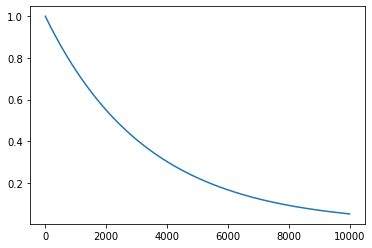

In [5]:
epsilon = []
max_epsilon = 1.0
min_epsilon = 0.001

# number of episodes for training : 10,000
episodes = np.arange(0, 10000)

for i in episodes:
    epsilon.append(min_epsilon +
                   (max_epsilon - min_epsilon) * np.exp(-0.0003 * i))

plt.plot(episodes, epsilon)
plt.show()

>  formula to calculate epsilon : **(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.0003 * i))**
-  minimum epsilon : 0.001
-  maximum epsilon : 1.0

### Agent Class
---

In [6]:
class DQNAgent:
    def __init__(self,
                 state_size,
                 action_size,
                 learning_rate=0.09,
                 gamma=0.95,
                 batch_size=32,
                 memory_length=2000,
                 nn_epochs=1):

        self.set_hyperparameters(state_size, action_size, learning_rate, gamma,
                                 batch_size, memory_length, nn_epochs)

        # environment object
        self.cab_environment = CabDriverEnvironment()

        # create main and target model
        self.model = self.build_model()

        # create a model directory
        self.create_model_dir()

    def set_hyperparameters(self, state_size, action_size, learning_rate,
                            gamma, batch_size, memory_length, nn_epochs):
        """ Hyperparameters used in training sample
        """
        # initialize state-size and action-size which is define the input and output neurons
        # of the neural network.
        #
        # state_size = number of locations(5) + hours in a day (24) + days in a week (7)
        # action_size = total number of possible actions from a given state i.e. ((m-1) * m) + 1
        #
        # number of neurons in the input layer : state_size
        # number of neurons in the output layer : action_size
        self.state_size = state_size
        self.action_size = action_size

        # define hyperparameters to be used for training the model
        self.hyperparameters = {
            'learning_rate': learning_rate,
            'gamma': gamma,
            'batch_size': batch_size,
            'memory_length': memory_length,
            'nn_epochs': nn_epochs
        }

        # replay memory for DQN
        self.replay_memory = collections.deque(
            maxlen=self.hyperparameters['memory_length'])

    def create_model_dir(self):
        """ Create a folder to store trained model
        """
        learning_rate, gamma, batch_size, memory_length = self.hyperparameters

        self.model_dir = 'rl_cab_model_arch1_lrate_{0}_gamma_{1}_batch_size_{2}_memory_length_{3}'.format(
            learning_rate, gamma, batch_size, memory_length)

        if not os.path.exists(self.model_dir):
            os.mkdir(self.model_dir)

    def build_model(self):
        """ Define neural network
        """
        model = Sequential()

        # Input layer : 'state_size'
        model.add(
            Dense(32,
                  input_dim=self.state_size,
                  activation='relu',
                  kernel_initializer='he_uniform'))

        # Hidden Layers
        model.add(Dense(32, activation='relu',
                        kernel_initializer='he_uniform'))

        # Output Layer : 'action_size'
        model.add(
            Dense(self.action_size,
                  activation='relu',
                  kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        model.summary()

        return model

    def get_action(self, state, episode):
        """ Choose an action for a given state and episode based on
            Epsilon-Greedy strategy
        """
        # calculate decay factor for a given episode
        epsilon = self.epsilon_min + (
            self.epsilon_max - self.epsilon_min) * np.exp(-0.0003 * episode)

        random_value = np.random.random()

        # fetch possible requests and their index for a given location
        # number of requests per location are calculated based on a poisson distribution
        request_index, possible_requests = self.cab_environment.get_requests_per_location(state)

        if random_value > epsilon:
            # exploitation

            # predict q-values of all possible actions for a given state
            encoded_state = self.cab_environment.state_encod_arch1(state)
            predicted_q_values = self.model.predict(encoded_state)

            # filter q-values corresponding to selected requests for a given location
            filter_q_values = [predicted_q_values[0][i] for i in request_index]

            # select index of an action corresponding to max Q-value
            index_max_q_value = np.argmax(np.array(filter_q_values))

            # select request with maximum q-value
            selected_action = possible_requests[index_max_q_value]

        else:
            # exploration

            # select a random request from possible request space
            selected_action = random.choice(possible_requests)

        return selected_action

    def append_sample(self, state, action, reward, next_state):
        """ Insert sample into replay memory buffer
        """
        self.replay_memory.append((state, action, reward, next_state))

    def save_model(self):
        file_name = self.model_dir + "/" + "dqn_model_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".model"
        self.model.save_weights(file_name)
        
    def train_model(self):
        """ Pick samples randomly from replay memory (with batch_size) and train the network
        """
        # start training only when the number of samples in memory > batch size
        if len(self.replay_memory) > self.hyperparameters['batch_size']:
            batch_size = self.hyperparameters['batch_size']

            # Sample batch from the memory
            mini_batch = random.sample(self.memory, batch_size)

            # initialize input state vector S
            encoded_state_input = np.zeros((batch_size, self.state_size))

            # initialize input state vector S'
            encoded_next_state_input = np.zeros((batch_size, self.state_size))

            action_list, reward_list = [], []

            # for each element in the mini-batch, update input vectors
            # with encoded state values
            for i in range(batch_size):
                state, action, reward, next_state = mini_batch[i]

                encoded_state = self.cab_environment.state_encod_arch1(state)
                encoded_state_input[i] = encoded_state

                encoded_next_state = self.cab_environment.state_encod_arch1(
                    next_state)
                encoded_next_state_input[i] = encoded_next_state

                action_list.append(action)
                reward_list.append(reward)

            # once the input matrices S and S' have been created, perform a feed-forward.
            # this will generate q-values for all possible actions of a batch input

            # generate Q(s, a)
            current_state_q_values = self.model.predict(encoded_state_input)

            # generate Q(s', a)
            next_state_q_values = self.model.predict(encoded_next_state_input)

            # for each element in the batch, update respective q-values using the
            # formula (r + maxQ(s',a))
            for i in range(batch_size):
                action_idx = list(
                    filter(
                        lambda x: self.cab_environment.action_space[x] == action_list[i],
                        range(0, len(self.cab_environment.action_space))))[0]
                
                # update q-values based on current model output
                current_state_q_values[i][action_idx] = reward_list[i] + (
                    self.hyperparameters['gamma'] *
                    np.max(next_state_q_values))
            
            # train the model with update Q-values
            self.model.fit(encoded_state_input,
                           current_state_q_values,
                           batch_size=batch_size,
                           epochs=self.hyperparameters['nn_epochs'],
                           verbose=0)